Support Vector machine

Data Loading

In [12]:
import pandas as pd

# Paths to your training data files
amazon_fashion_path = '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/AMAZON_FASHION.json'
all_beauty_path = '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/All_Beauty.json'
clothing_shoes_jewelry_path = '/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Clothing_Shoes_and_Jewelry.json'


# Number of rows to read from each file
n_rows = 1000

# Load a subset of each training dataset
amazon_fashion = pd.read_json(amazon_fashion_path, lines=True, nrows=n_rows)
all_beauty = pd.read_json(all_beauty_path, lines=True, nrows=n_rows)
clothing_shoes_jewelry = pd.read_json(clothing_shoes_jewelry_path, lines=True, nrows=n_rows)

# Concatenate the datasets
training_data = pd.concat([amazon_fashion, all_beauty, clothing_shoes_jewelry])

Text Preprocessing 

In [13]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        tokens = word_tokenize(text)
        lemmatized_text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens if word not in stop_words])
        return lemmatized_text
    else:
        return ""

# Apply the preprocessing to your training data
training_data['processed_reviewText'] = training_data['reviewText'].apply(preprocess_text)
training_data = training_data[training_data['processed_reviewText'] != ""]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/patrickbendorffschwebel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


data preparation with balance

In [6]:
from sklearn.model_selection import train_test_split

# Categorizing the ratings
def cat_y(overall_rating):
    if overall_rating in [1, 2]:
        return 'low'
    elif overall_rating == 3:
        return 'neutral'
    elif overall_rating in [4, 5]:
        return 'high'

training_data['category'] = training_data['overall'].apply(cat_y)

# Balancing the dataset
def balance_dataset(data, target_column):
    min_size = data[target_column].value_counts().min()
    lst = [data[data[target_column] == category].sample(min_size, random_state=42) for category in data[target_column].unique()]
    balanced_data = pd.concat(lst).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_data

balanced_training_data = balance_dataset(training_data, 'category')

data preparation wihtout balance

In [14]:
from sklearn.model_selection import train_test_split

# Categorizing the ratings
def cat_y(overall_rating):
    if overall_rating in [1, 2]:
        return 'low'
    elif overall_rating == 3:
        return 'neutral'
    elif overall_rating in [4, 5]:
        return 'high'

training_data['category'] = training_data['overall'].apply(cat_y)

 Feature with balance 

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()
balanced_training_data['sentiment_score'] = balanced_training_data['processed_reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Apply TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_features_balanced = tfidf_vectorizer.fit_transform(balanced_training_data['processed_reviewText'])

# Combine TF-IDF features with sentiment scores
combined_features_balanced = hstack([tfidf_features_balanced, balanced_training_data['sentiment_score'].values.reshape(-1, 1)])


# Preprocess the balanced data
balanced_training_data['processed_reviewText'] = balanced_training_data['reviewText'].apply(preprocess_text)
balanced_training_data = balanced_training_data[balanced_training_data['processed_reviewText'] != ""]

# Apply feature engineering to the balanced dataset
balanced_training_data['sentiment_score'] = balanced_training_data['processed_reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
tfidf_features_balanced = tfidf_vectorizer.fit_transform(balanced_training_data['processed_reviewText'])
combined_features_balanced = hstack([tfidf_features_balanced, balanced_training_data['sentiment_score'].values.reshape(-1, 1)])

# Preparing the data for the model
X_train, X_val, y_train, y_val = train_test_split(combined_features_balanced, balanced_training_data['category'], test_size=0.2, random_state=42)

 Feature without balance 

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()
training_data['sentiment_score'] = training_data['processed_reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Apply TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_features = tfidf_vectorizer.fit_transform(training_data['processed_reviewText'])

# Combine TF-IDF features with sentiment scores
combined_features = hstack([tfidf_features, training_data['sentiment_score'].values.reshape(-1, 1)])


# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(combined_features, training_data['category'], test_size=0.2, random_state=42)

model train with balance 

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearch
param_grid_svm = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly']  # Specifies the kernel type
}

# Create a GridSearchCV object
grid_search_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=5, scoring='accuracy')

# Fit the model on the training data
grid_search_svm.fit(X_train, y_train)

# Best estimator
svm_model = grid_search_svm.best_estimator_


model train without balance 

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearch
param_grid_svm = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly'],  # Specifies the kernel type
    'class_weight': ['balanced']  # Add class weights
}

# Create a GridSearchCV object with class_weight='balanced'
grid_search_svm = GridSearchCV(SVC(random_state=42, class_weight='balanced'), param_grid_svm, cv=5, scoring='accuracy')

# Fit the model on the training data
grid_search_svm.fit(X_train, y_train)

# Best estimator
svm_model = grid_search_svm.best_estimator_



Model Evaluation

              precision    recall  f1-score   support

        high       0.88      0.97      0.93       503
         low       0.72      0.42      0.53        55
     neutral       0.25      0.07      0.11        41

    accuracy                           0.86       599
   macro avg       0.62      0.49      0.52       599
weighted avg       0.82      0.86      0.83       599

Accuracy: 0.8614357262103506
Recall: 0.4885025398238801
F1 Score: 0.5227397239307608


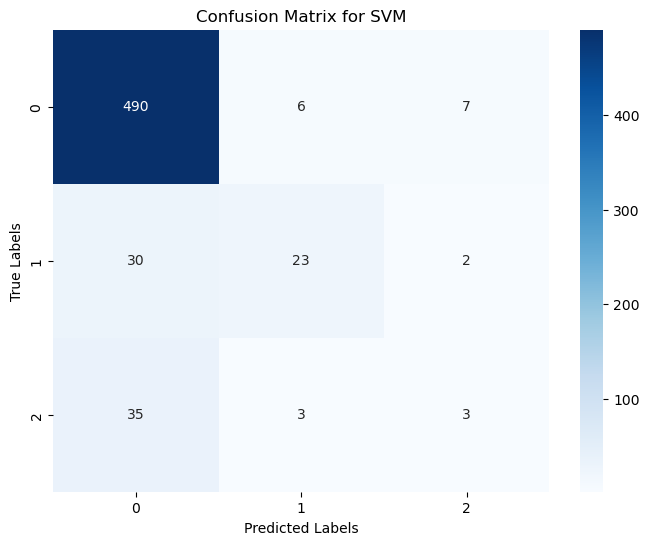

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Predictions on validation set
y_val_pred_svm = svm_model.predict(X_val)

# Classification report
print(classification_report(y_val, y_val_pred_svm))

# Additional metrics
accuracy = accuracy_score(y_val, y_val_pred_svm)
recall = recall_score(y_val, y_val_pred_svm, average='macro')
f1 = f1_score(y_val, y_val_pred_svm, average='macro')

print(f"Accuracy: {accuracy}\nRecall: {recall}\nF1 Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


model performance 

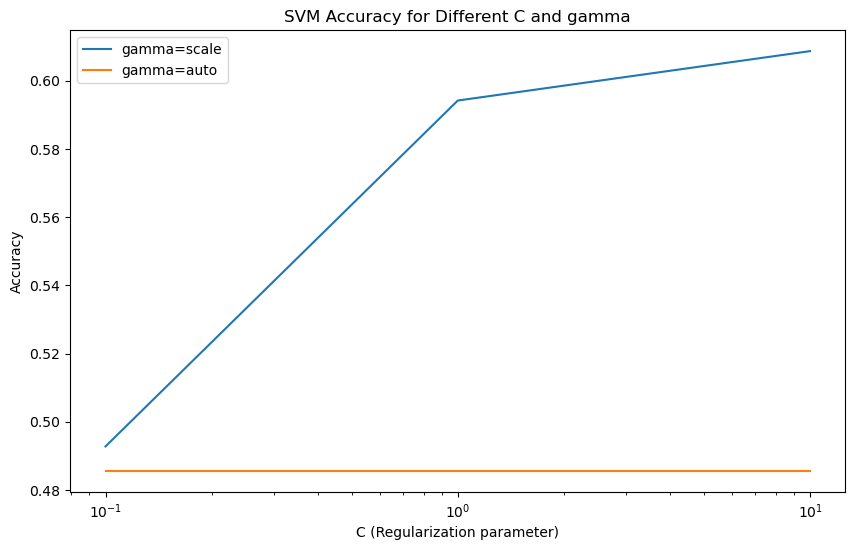

In [10]:
import numpy as np

# Define ranges for C and gamma
C_range = [0.1, 1, 10]
gamma_range = ['scale', 'auto']
kernel = 'rbf'  # You can change this to other kernels like 'linear' or 'poly'

# Store the results
results = []

for C in C_range:
    for gamma in gamma_range:
        svm = SVC(kernel=kernel, C=C, gamma=gamma, random_state=42)
        svm.fit(X_train, y_train)
        y_val_pred = svm.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)
        results.append((C, gamma, accuracy))

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results, columns=['C', 'gamma', 'accuracy'])

# Plotting
plt.figure(figsize=(10, 6))
for gamma in gamma_range:
    subset = results_df[results_df['gamma'] == gamma]
    plt.plot(subset['C'], subset['accuracy'], label=f'gamma={gamma}')

plt.title('SVM Accuracy for Different C and gamma')
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Accuracy')
plt.xscale('log')  # Because C values vary in orders of magnitude
plt.legend()
plt.show()


test på lux

In [11]:
# Load test dataset
test_data = pd.read_json('/Users/patrickbendorffschwebel/Desktop/Anvendt-kode/anvendt-exam/mappe uden navn 2/Luxury_Beauty.json', lines=True, nrows=1000)

# Preprocess the text data
test_data['processed_reviewText'] = test_data['reviewText'].apply(preprocess_text)

# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()
test_data['sentiment_score'] = test_data['processed_reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Apply the same TF-IDF vectorizer to the test data
tfidf_features_test = tfidf_vectorizer.transform(test_data['processed_reviewText'])

# Combine TF-IDF features with sentiment scores
combined_features_test = hstack([tfidf_features_test, test_data['sentiment_score'].values.reshape(-1, 1)])

# Categorize the ratings in the test data
test_data['category'] = test_data['overall'].apply(cat_y)

# Predict with the trained SVM model
# Ensure svm_model is your trained SVM model
test_predictions_svm = svm_model.predict(combined_features_test)

# Evaluate the model's performance
print(classification_report(test_data['category'], test_predictions_svm))


              precision    recall  f1-score   support

        high       0.94      0.86      0.90       868
         low       0.40      0.62      0.49        82
     neutral       0.10      0.16      0.12        50

    accuracy                           0.80      1000
   macro avg       0.48      0.55      0.50      1000
weighted avg       0.85      0.80      0.82      1000



improve: 

Hyperparameter Tuning:
C (Regularization Parameter): Adjusting the C parameter can help control the trade-off between smooth decision boundaries and classifying training points correctly. A low value encourages a smoother decision boundary, while a higher value aims to classify more training points correctly, potentially leading to overfitting.
Kernel Choice: Different kernels (like linear, polynomial, RBF) can significantly impact performance. The choice depends on the nature of your data. For instance, non-linear kernels like RBF might perform better on complex datasets.
Gamma (Kernel Coefficient for RBF, Polynomial, and Sigmoid): In the RBF kernel, gamma defines how far the influence of a single training example reaches. Low values mean ‘far’ and high values mean ‘close’. Adjusting gamma can help with the model's ability to handle the complexity of the feature space.
Feature Engineering:
Experiment with different text representation methods like word embeddings (Word2Vec, GloVe) which might capture semantic relationships better than TF-IDF.
Add additional features that might be relevant to the prediction task, such as length of the review, readability scores, or specific sentiment markers.
Normalize or scale features, especially if you're combining different types of data (like numerical and textual data).
Data Preprocessing:
Further clean and preprocess your text data. This might include more advanced natural language processing techniques like named entity recognition, part-of-speech tagging, or syntax parsing.
Consider handling class imbalance more rigorously, possibly using techniques like SMOTE (Synthetic Minority Over-sampling Technique) or adjusting class weights in the SVM algorithm.
Model Selection and Ensemble Methods:
Sometimes a different model might be more suitable for your data. Consider trying other algorithms like Random Forest, Gradient Boosting Machines, or Neural Networks.
Use ensemble methods. Bagging (Bootstrap Aggregating) or boosting techniques can sometimes improve the performance by combining multiple weak models into a more robust model.
Cross-Validation and Grid Search:
Use more extensive cross-validation schemes to evaluate your model performance, like K-Fold cross-validation.
Employ grid search or randomized search for more extensive hyperparameter tuning.
Domain-Specific Knowledge:
Incorporate domain-specific knowledge into feature engineering. For instance, if the dataset is about product reviews, features like the mention of certain product attributes might be useful.
Evaluating Different Performance Metrics:
Depending on your problem, evaluate the model using different metrics like precision, recall, F1-score, ROC-AUC, etc., and choose the one that aligns best with your business objectives or use case.
Remember, improving a model is an iterative process. It's important to experiment and evaluate the impact of different changes on your model's performance. Also, consider the trade-offs between model complexity, interpretability, and performance.